# Saddle point systems

In [2]:
using ConstrainedSystems

In [3]:
using LinearAlgebra

In [4]:
using Plots
default(grid = false)

### Working with matrices
Let's see how `SaddleSystems` work with matrices. We will solve the system

$$
\begin{bmatrix} 1 & 2 & 2 & -1 \\ 2 & 1 & 3 & -1 \\ 2 & 3 & 5 & -2\\ -1 & -1 & 3 & -4\end{bmatrix} \begin{pmatrix}s_1 \\ s_2 \\ s_3 \\ s_4 \end{pmatrix} = \begin{pmatrix} 1 \\ 2 \\ 3\\ 4\end{pmatrix}
$$

In [5]:
A = [1.0 2.0; 2.0 1.0] 
B2 = [2.0 3.0;-1.0 -1.0]
B1t = B2'
C =  [5.0 -2.0; 3.0 -4.0]
rhs1v = [1.0,2.0];
rhs2v = [3.0,4.0];

#### Let's first get the solution the usual way

In [12]:
Amat = [A B1t; B2 C]
rhsv = [rhs1v;rhs2v];

In [13]:
@time solv = Amat\rhsv

  0.000015 seconds (3 allocations: 384 bytes)


4-element Vector{Float64}:
  5.551115123125783e-17
 -0.3571428571428571
  0.6428571428571428
 -0.4285714285714286

#### Now let's solve as a SaddleSystem
We will divide this into four 2x2 blocks

In [14]:
As = SaddleSystem(A,B2,B1t,C)

Saddle system with 2 states and 2 constraints and
   State vector of type Vector{Float64}
   Constraint vector of type Vector{Float64}
   Elements of type Float64
using a Direct solver


We can solve this the same way, using `\` on the $4x1$ vector `rhsv`

In [15]:
@time solv2 = As\rhsv

  0.000143 seconds (32 allocations: 1.594 KiB)


4-element Vector{Float64}:
  0.0
 -0.3571428571428572
  0.6428571428571428
 -0.42857142857142877

Suppose we simply wish to obtain the constraint part from the state part (via inversion of the C operator)

In [16]:
solv3 = deepcopy(solv2)
solv3[3:end] .= 0.0
constraint_from_state!(solv3,As,rhsv)

4-element Vector{Float64}:
  0.0
 -0.3571428571428572
  0.6428571428571428
 -0.42857142857142866

#### Iterative solver
The default is to store the Schur complement matrix, factorize it, and solve the problem directly. We can also use an iterative solver, specified with the `solver = ` keyword argument. The choices are `Direct` (default), `CG`, `BiCGStabl`, `GMRES`, `MINRES`, and `IDRS`. The `CG` and `MINRES` methods should only be used for symmetric systems. These iterative solvers make use of the `IterativeSolvers` package, and their optional arguments can be included in the `SaddleSystem` call.

In [17]:
As_iter = SaddleSystem(A,B2,B1t,C,solver=BiCGStabl)

Saddle system with 2 states and 2 constraints and
   State vector of type Vector{Float64}
   Constraint vector of type Vector{Float64}
   Elements of type Float64
using a BiCGStabl solver


In [19]:
@time As_iter\rhsv

  0.000089 seconds (81 allocations: 5.766 KiB)


4-element Vector{Float64}:
 -1.3322676295501878e-15
 -0.35714285714285704
  0.6428571428571442
 -0.428571428571427

#### More general form
The previous form of constructor works only for matrices. A more general form requires that we tell it the form of the *state* and *constraint* parts of the solution and right-hand side vectors. We can use `SaddleVector` to assemble these together into a single vector:

In [20]:
rhs = SaddleVector(rhs1v,rhs2v)

([1.0, 2.0], [3.0, 4.0])

The vector `rhs` is an `ArrayPartition` type:

In [21]:
typeof(rhs)

RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}

Here, we construct the system:

In [22]:
@time As = SaddleSystem(A,B2,B1t,C,rhs)

  0.281600 seconds (596.90 k allocations: 39.484 MiB, 3.21% gc time, 99.50% compilation time)


Saddle system with 2 states and 2 constraints and
   State vector of type Vector{Float64}
   Constraint vector of type Vector{Float64}
   Elements of type Float64
using a Direct solver


and solve it in the usual way:

In [23]:
@time sol = As\rhs

  0.090738 seconds (205.19 k allocations: 13.886 MiB, 99.64% compilation time)


([0.0, -0.3571428571428572], [0.6428571428571428, -0.42857142857142877])

The solution is of the same `ArrayPartition form`

In [24]:
typeof(sol)

RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}

We can get the *state* and *constraint* parts of any `SaddleVector` with convenience functions:

In [25]:
state(sol)

2-element Vector{Float64}:
  0.0
 -0.3571428571428572

In [26]:
constraint(sol)

2-element Vector{Float64}:
  0.6428571428571428
 -0.42857142857142877

We can also multiply:

In [27]:
As*sol

([1.0, 2.0], [2.9999999999999996, 4.0])

Once again, we can get the constraint from the state:

In [28]:
sol2 = deepcopy(sol)
constraint(sol2) .= 0.0
constraint_from_state!(sol2,As,rhs)

([0.0, -0.3571428571428572], [0.6428571428571428, -0.42857142857142866])

In [29]:
constraint(sol2) ≈ constraint(sol)

true

### Unconstrained solution
Of course, we can use this with *unconstrained* systems without problem. For example, let's consider our example as the full matrix. We pass in an empty vector for the constraints:

In [30]:
nada = empty(rhsv);
rhsnc = SaddleVector(rhsv,nada)
Anc = SaddleSystem(Amat,rhsnc)

Saddle system with 4 states and 0 constraints and
   State vector of type Vector{Float64}
   Constraint vector of type Vector{Type{Float64}}
   Elements of type Float64
using a Direct solver


In [31]:
solnc = Anc\rhsnc

([5.551115123125783e-17, -0.3571428571428571, 0.6428571428571428, -0.4285714285714286], Float64[])

In [32]:
state(solnc)

4-element Vector{Float64}:
  5.551115123125783e-17
 -0.3571428571428571
  0.6428571428571428
 -0.4285714285714286

In [33]:
constraint(solnc)

Float64[]

And if we multiply, we get back what we expect:

In [34]:
Anc*solnc

([1.0, 2.0, 3.0, 4.0], Float64[])

This time, we cannot get the constraint from the state, because there is no C operator

In [35]:
solnc2 = deepcopy(solnc)
constraint(solnc2) .= 0.0
constraint_from_state!(solnc2,Anc,rhsnc)

LoadError: C operator cannot be inverted

### More interesting operators
Let's try this on `CartesianGrids` field operators. We will construct a square grid of points and immerse a bunch of points in it. Our goal is to solve

$$
\begin{bmatrix} L & R \\ E & 0 \end{bmatrix} \begin{pmatrix} \psi \\ f \end{pmatrix} =  \begin{pmatrix} -w \\ \psi_b \end{pmatrix}
$$

where $\psi$ is the discrete streamfunction, $w$ the discrete vorticity, and $\psi_b$ a prescribed distribution of streamfunction on the body surface.

In [36]:
using CartesianGrids

In [37]:
nx = 130; ny = 130;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));
u = similar(w);

Set up a Laplace operator on this grid, and make sure it has an inverse:

In [38]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 130, ny = 130) grid acting on Float64 data with
               factor 1.0 and spacing 1.0

Set up points along a circle

In [39]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
ψb = ScalarData(X);

Create the regularization and interpolation operators:

In [40]:
E = Regularize(X,dx;issymmetric=true)
Rmat,Emat = RegularizationMatrix(E,ψb,w);

Now we set up the system

In [41]:
u = SaddleVector(w,ψb);
@time A = SaddleSystem(L,Emat,Rmat,u) #,solver=BiCGStabl,tol=1e-3)

  0.695532 seconds (2.20 M allocations: 190.316 MiB, 6.59% gc time, 89.44% compilation time)


Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual, 130, 130, Float64, Matrix{Float64}}
   Constraint vector of type ScalarData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


and the right-hand side vector

In [42]:
ψb .= -(xb .- 1);
rhs = SaddleVector(w,ψb)

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-0.5, -0.4993977281025863, -0.4975923633360986, -0.49458825498239056, -0.4903926402016152, -0.48501562659727204, -0.4784701678661043, -0.47077203259151035, -0.4619397662556435, -0.4519946465617217  …  -0.44096063217417747, -0.4519946465617215, -0.46193976625564326, -0.47077203259151035, -0.4784701678661043, -0.48501562659727204, -0.4903926402016152, -0.49458825498239056, -0.4975923633360986, -0.4993977281025863])

and solve it...

In [43]:
@time sol = A\rhs;

  0.235139 seconds (616.66 k allocations: 42.016 MiB, 4.63% gc time, 99.39% compilation time)


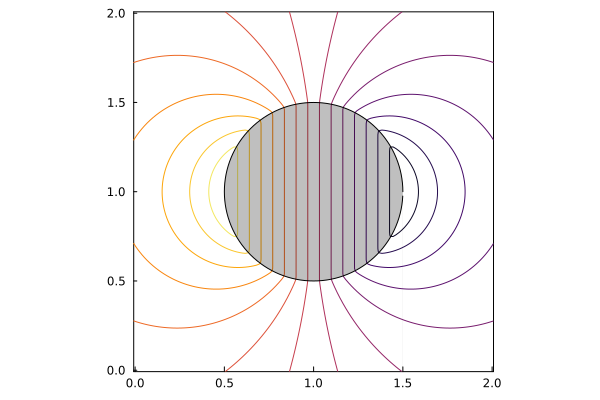

In [44]:
xg,yg = coordinates(w,dx=dx)
plot(xg,yg,state(sol))
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Plot the constraint vector and compare it with the exact solution (for the continuous problem):

In [45]:
fex = -2*cos.(θ[1:n])*ds;

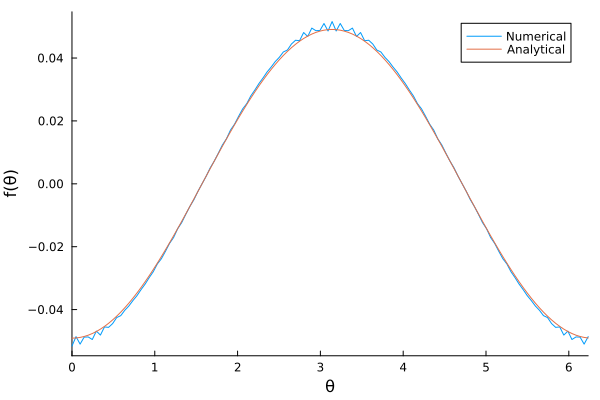

In [46]:
plot(θ[1:n],constraint(sol),label="Numerical",xlabel="θ",ylabel="f(θ)",xlim=(-Inf,Inf))
plot!(θ[1:n],fex,label="Analytical")

The L2 norm of the difference

In [47]:
norm(constraint(sol)-fex)

0.010176487612400299

### Unconstrained case with Edges data

In [48]:
rhsq = Edges(Primal,w);
rhsq.u .= 3;

In [49]:
Aq = SaddleSystem(I,SaddleVector(rhsq,nada));

In [50]:
@time sol = Aq\SaddleVector(rhsq,nada)

  0.153348 seconds (453.93 k allocations: 31.609 MiB, 99.34% compilation time)


(Primal edges for a (nx = 130, ny = 130) cell grid of type Float64 data
  Internal u-faces: (nx = 130, ny = 129)
  Internal v-faces: (nx = 129, ny = 130), Float64[])

In [51]:
q = state(sol);

In [52]:
all(q.u .== 3.0) && all(q.v .== 0.0)

true

### Filtering
Sometimes we might wish to apply a linear filter to the solution for the constraint forces. We can define such a filter in the same way that we define the other operators. It is passed in via the `filter=` keyword argument. This argument defaults to the identity.

Let's try this on our earlier example, using the filtering operation associated with Regularization/Interpolation with re-scaling:

In [53]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,ψb,w);
Ẽmat = InterpolationMatrix(Ẽ,w,ψb);

We define our filtering operator as a product of these two operators:

In [54]:
Pmat = Ẽmat*H̃mat;

In [55]:
u = SaddleVector(w,ψb);
Afilt = SaddleSystem(L,Emat,Rmat,u,filter=Pmat)

Saddle system with 16900 states and 128 constraints and
   State vector of type Nodes{Dual, 130, 130, Float64, Matrix{Float64}}
   Constraint vector of type ScalarData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


In [56]:
ψb .= -(xb .- 1);
rhs = SaddleVector(w,ψb);

In [57]:
sol = Afilt\rhs;

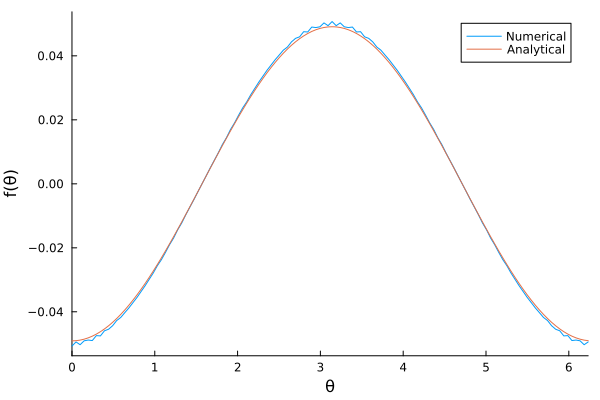

In [58]:
plot(θ[1:n],constraint(sol),label="Numerical",xlabel="θ",ylabel="f(θ)",xlim=(-Inf,Inf))
plot!(θ[1:n],fex,label="Analytical")

Notice that the solution is less noisy than without it, and the comparison with the exact result is more favorable:

In [59]:
norm(constraint(sol)-fex)

0.008383851513017036

### Another interesting example
This time, we will solve a similar problem, but this time setting a surface velocity (requiring `VectorData`) and determining the vorticity (the state vector):


$$
\begin{bmatrix} I & C^{T}R \\ -ECL^{-1} & 0 \end{bmatrix} \begin{pmatrix} w \\ f \end{pmatrix} =  \begin{pmatrix} 0 \\ u_b \end{pmatrix}
$$

where $I$ is the identity and $u_b$ is the surface velocity.

In [60]:
# surface velocity
ub = VectorData(X);

# a grid velocity field
q = Edges(Primal,w);

# and regularization and interpolation operators
Rvmat,Evmat = RegularizationMatrix(E,ub,q);

Now, define the state-constraint operators as functions

In [61]:
B₁ᵀ(f) = Curl()*(Rvmat*f);

In [62]:
B₂(w) = -(Evmat*(Curl()*(L\w)))

B₂ (generic function with 1 method)

In [63]:
rhs = SaddleVector(w,ub)
A = SaddleSystem(I,B₂,B₁ᵀ,rhs)

Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual, 130, 130, Float64, Matrix{Float64}}
   Constraint vector of type VectorData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


In [65]:
ub.u .= 0.0 #-sin.(4θ[1:n]);
ub.v .= 1.0; # cos.(4θ[1:n]);
#rhs = SaddleVector(w,ub); 

Note that the assignements to `ub` automatically update the `rhs` vector:

In [66]:
constraint(rhs)

128 points of vector-valued Float64 data
256-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [67]:
sol = A\rhs;

Plot the streamlines:

In [68]:
ψ = -(L\state(sol));

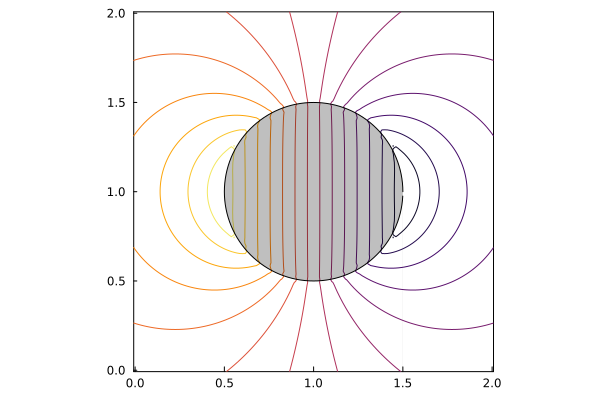

In [69]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

#### Now, we will solve the same problem, but with diffusion, handled by an integrating factor

$$
\begin{bmatrix} H(-\Delta t) & C^{T}R \\ -ECL^{-1} & 0 \end{bmatrix} \begin{pmatrix} w \\ f \end{pmatrix} =  \begin{pmatrix} 0 \\ u_b \end{pmatrix}
$$

where $H(t)$ is the linear diffusion operator.

In [87]:
Δt = 2.0
Hdt = exp(L,-Δt,w)

Integrating factor with parameter -2.0 on a (nx = 130, ny = 130) grid

Form the saddle-point system:

In [88]:
A = SaddleSystem(Hdt,B₂,B₁ᵀ,rhs)

Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual, 130, 130, Float64, Matrix{Float64}}
   Constraint vector of type VectorData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


Solve it for surface velocity associated with a deforming surface.

In [84]:
ub.u .= cos.(4θ[1:n]);
ub.v .= -sin.(4θ[1:n]);
rhs = SaddleVector(w,ub);

In [85]:
sol = A\rhs

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-5.35092298538116, -4.693917369948895, -4.980692868394229, -4.778729268151976, -4.171546560203051, -4.479623069613907, -2.7404533589387676, -3.603236742804278, -0.9697336031768213, -1.90660408829705  …  -3.9959438750291874, -9.95577760258687, -4.477621489206045, -11.508211164099183, -5.104240643217055, -9.202761395365822, -6.345301932130212, -4.488872528912419, -4.556040785378001, -1.4857558594470737])

Let's inspect the vorticity in this case:

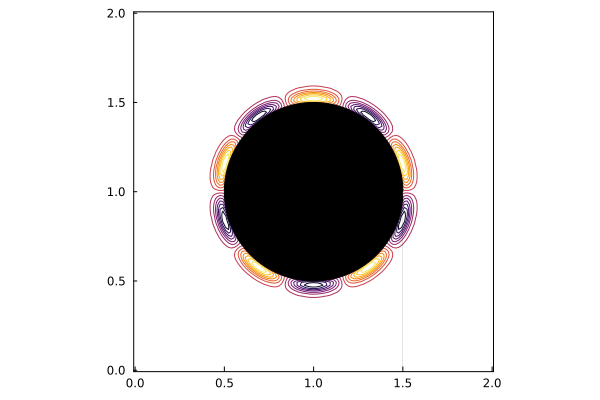

In [86]:
w = state(sol);
xg,yg = coordinates(w,dx=dx)
plot(xg,yg,w)
plot!(xb,yb,fillcolor=:black,fillrange=0,linecolor=:black)

### Set of saddle point systems
We can solve a **set** of saddle point systems. The ones we set up here are completely decoupled. We group the individual saddle point systems into a tuple:

In [89]:
sys = (A,Anc)

(Saddle system with 16900 states and 256 constraints and
   State vector of type Nodes{Dual, 130, 130, Float64, Matrix{Float64}}
   Constraint vector of type VectorData{128, Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver
, Saddle system with 4 states and 0 constraints and
   State vector of type Vector{Float64}
   Constraint vector of type Vector{Type{Float64}}
   Elements of type Float64
using a Direct solver
)

We provide a tuple of right-hand side vectors (each of type `SaddleVector`), and get a tuple of solutions:

In [90]:
sol1, sol2 = sys\(rhs,rhsnc);

In [91]:
sol1

(Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [-5.35092298538116, -4.693917369948895, -4.980692868394229, -4.778729268151976, -4.171546560203051, -4.479623069613907, -2.7404533589387676, -3.603236742804278, -0.9697336031768213, -1.90660408829705  …  -3.9959438750291874, -9.95577760258687, -4.477621489206045, -11.508211164099183, -5.104240643217055, -9.202761395365822, -6.345301932130212, -4.488872528912419, -4.556040785378001, -1.4857558594470737])

In [92]:
sol2

([5.551115123125783e-17, -0.3571428571428571, 0.6428571428571428, -0.4285714285714286], Float64[])

We can check that these are the same as the problems solved individually (since they are uncoupled in this example):

In [93]:
sol1 == sol

true

In [94]:
sys*(sol1,sol2)

(RecursiveArrayTools.ArrayPartition{Float64, Tuple{Nodes{Dual, 130, 130, Float64, Matrix{Float64}}, VectorData{128, Float64, Vector{Float64}}}}((Dual nodes in a (nx = 130, ny = 130) cell grid of type Float64 data
  Number of Dual nodes: (nx = 130, ny = 130), [0.999999999999999, 0.9807852804032312, 0.923879532511286, 0.8314696123025452, 0.7071067811865487, 0.5555702330196024, 0.3826834323650897, 0.195090322016129, 6.263309424902263e-16, -0.19509032201612908  …  0.923879532511286, 0.9807852804032298, 1.000000000000001, 0.9807852804032309, 0.9238795325112867, 0.8314696123025458, 0.7071067811865481, 0.5555702330196048, 0.38268343236508934, 0.19509032201612891])), RecursiveArrayTools.ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}(([1.0, 2.0, 3.0, 4.0], Float64[])))

### Define minimal wrapper type
Here, we demonstrate the needs of a data wrapper for `SaddleSystem`

In [5]:
# Basic structure of the wrapper
struct MyWrapper{T,DT} <: AbstractVector{T}
    data :: DT
end

# Basic constructor
MyWrapper(data::AbstractVector{T}) where {T} = MyWrapper{eltype(data),typeof(data)}(data)

MyWrapper

In [6]:
# set up basic array stuff
Base.size(A::MyWrapper) = size(A.data)
Base.size(A::MyWrapper,d::Int) = size(A.data,d)
Base.@propagate_inbounds Base.getindex(A::MyWrapper,i::Int) = getindex(A.data,i)
Base.@propagate_inbounds Base.setindex!(A::MyWrapper, v, i::Int) = setindex!(A.data,v,i)
Base.similar(A::MyWrapper) = MyWrapper(similar(A.data))
Base.zero(A::MyWrapper{T,DT}) where {T,DT} = MyWrapper(zero(A.data))

In [7]:
# set up basic arithmetic so that matrix operators work on them properly
using LinearAlgebra
import LinearAlgebra: mul!,*,\
mul!(y::MyWrapper,A::Matrix,x::MyWrapper) = (mul!(y.data,A,x.data); return y)
mul!(y::MyWrapper,A::ConstrainedSystems.LinearMap,x::MyWrapper) = (mul!(y.data,A,x.data); return y)


(*)(A::Matrix,x::MyWrapper) = (y = similar(x); mul!(y,A,x); return y)
(\)(A::Matrix,x::MyWrapper) = (y = similar(x); y.data .= A\x.data; return y)


\ (generic function with 243 methods)

In [8]:
f = MyWrapper(1.0:5.0)

5-element MyWrapper{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}:
 1.0
 2.0
 3.0
 4.0
 5.0

Return to the old matrix system

In [9]:
A = [1.0 2.0; 2.0 1.0] 
B2 = [2.0 3.0;-1.0 -1.0]
B1t = B2'
C =  [5.0 -2.0; 3.0 -4.0]
rhs1v = [1.0,2.0];
rhs2v = [3.0,4.0];

In [10]:
rhs1 = MyWrapper(rhs1v)
rhs2 = MyWrapper(rhs2v);
rhs = SaddleVector(rhs1,rhs2)

([1.0, 2.0], [3.0, 4.0])

In [11]:
@time As = SaddleSystem(A,B2,B1t,C,rhs)

  0.642899 seconds (1.99 M allocations: 134.257 MiB, 6.38% gc time, 99.63% compilation time)


Saddle system with 2 states and 2 constraints and
   State vector of type MyWrapper{Float64, Vector{Float64}}
   Constraint vector of type MyWrapper{Float64, Vector{Float64}}
   Elements of type Float64
using a Direct solver


In [12]:
@time sol = As\rhs

  0.162303 seconds (447.22 k allocations: 30.123 MiB, 5.90% gc time, 99.74% compilation time)


([0.0, -0.3571428571428572], [0.6428571428571428, -0.42857142857142877])

In [13]:
As*sol

([1.0, 2.0], [2.9999999999999996, 4.0])

In [14]:
rhs

([1.0, 2.0], [3.0, 4.0])

### [WIP] Saddle system of a saddle system

First, try a basic matrix system

In [94]:
# A 3 x 3 upper left block, treated as a saddle system
A1 = Amat[1:2,1:2]
B21 = Amat[3:3,1:2];
B11t = B21';
C1 = Amat[3:3,3:3]
rhs11v = rhsv[1:2];
rhs12v = rhsv[3:3];

rhs1 = SaddleVector(rhs11v,rhs12v)

A = SaddleSystem(A1,B21,B11t,C1,rhs1)

Saddle system with 2 states and 1 constraints and
   State vector of type Array{Float64,1}
   Constraint vector of type Array{Float64,1}
   Elements of type Float64
using a Direct solver


In [95]:
# Now the constraint blocks for the outer saddle system
B22 = Amat[4:4,1:3];
B12t = Amat[1:3,4:4];
C2 = Amat[4:4,4:4];

# and the rhs for its constraint
rhs2 = rhsv[4:4];

rhsbig = SaddleVector(rhs1,rhs2)
#Abig = SaddleSystem(A,B22p,B12tp,C2,rhsbig);

In [96]:
y = B22p*(A\(B12tp*rhs2))

UndefVarError: UndefVarError: B12tp not defined

In [97]:
B22p = ArrayPartition(view(B22,:,1:2),view(B22,:,3:3))
B12tp = ArrayPartition(view(B12t,1:2,:),view(B12t,3:3,:))

UndefVarError: UndefVarError: ArrayPartition not defined

In [340]:
B22p*y

1-element Array{Float64,1}:
 -1.9999999999999987

In [337]:
function mul!(y::AbstractVector,Ap::ArrayPartition,x::ArrayPartition)
    fill!(y,0.0)
    for (i,A) in enumerate(Ap.x)
        y .+= A*vec(x.x[i])
    end
    return y
end
(*)(Ap::ArrayPartition{T},x::ArrayPartition{T}) where {T} = mul!(zeros(T,size(Ap.x[1],1)),Ap,x)

* (generic function with 504 methods)

In [336]:
vec(y.x[1])

2-element Array{Float64,1}:
 -4.440892098500626e-16
 -1.0                  

In [279]:
all(size.(B12tp.x,2) .== 1)

true

In [314]:
function mul!(y::ArrayPartition,Ap::ArrayPartition,x::AbstractVector)
    all(size.(Ap.x,2) .== 1) || error("Inconsistent column numbers in partition.")
    fill!(y,0.0)
    for (i,A) in enumerate(Ap.x)
        y.x[i] .+= A*x
    end
    return y
end
(*)(Ap::ArrayPartition{T},x::AbstractVector{T}) where {T} = mul!(similar(Ap,Float64,Float64),Ap,x)

* (generic function with 504 methods)

In [312]:
y = similar(B12tp,Float64,Float64)

([5.0e-324; 2.216656405e-314], [1.99196138e-315])

In [311]:
y.x[1]

2×1 Array{Array{Float64,1},2}:
 #undef
 #undef

In [315]:
B12tp*rhs2

([-4.0; -4.0], [-8.0])

In [159]:
@time convert(Vector,rhs1)

  0.000014 seconds (9 allocations: 400 bytes)


3-element Array{Float64,1}:
 1.0
 2.0
 3.0

In [152]:
B22*rhs1

DimensionMismatch: DimensionMismatch("result C has length 3, needs length 1")

In [16]:
# rhs1 is the RHS array for the inner saddle point system
rhs11 = [1.0,2.0];
rhs12 = Vector{Float64}(undef,1)
rhs12 .= 3.0;
#rhs1 = (rhs11,rhs12)
rhs1 = [rhs11;rhs12];
sol1 = zero(rhs1)

# rhs2 is the RHS array for the remainder of the outer saddle system
rhs2 = Vector{Float64}(undef,1)
rhs2 .= 4.0;
sol2 = zero(rhs2)

rhs = (rhs1,rhs2);
sol = (sol1,sol2);

In [17]:
Abig = SaddleSystem(A,B22,B12,C2,rhs1,rhs2);

In [18]:
sol = Abig\rhs

([-4.440892098500626e-16, -0.3571428571428571, 0.6428571428571432], [-0.4285714285714282])

In [19]:
out = Abig*sol

([1.0, 1.9999999999999998, 3.0000000000000004], [4.0])

In [20]:
norm(out[1]-rhs1)

4.965068306494546e-16